# CO₂ Forecasting Using Random Forest and SARIMA
### A Hybrid Machine Learning and Time Series Approach for CO₂ Analysis and Forecast

## 📚 Table of Contents
<details open>
<summary>Click to expand</summary>

- 🔹 [Part A – Data Preparation and Library Imports](#part-a--data-preparation-and-library-imports)
- 🔹 [Part B – Train and Evaluate the Random Forest Model](#part-b--train-and-evaluate-the-random-forest-model)
- 🔹 [Part C – Permutation Feature Importance](#part-c--permutation-feature-importance)
- 🔹 [Part D – Save Model, Export Predictions, and Visualize Results](#part-d--save-model-export-predictions-and-visualize-results)
- 🔹 [Part E – Time Series Forecasting Using SARIMA](#part-e--time-series-forecasting-using-sarima)
- 🔹 [Part F – Seasonal Decomposition of Predicted CO₂](#part-f--seasonal-decomposition-of-predicted-co2)
- 🔹 [Conclusion](#-conclusion)

</details>

### 🔹 Part A – Data Preparation and Library Imports

This section imports the required libraries and loads the dataset that will be used throughout the workflow.

#### 📚 Imported Libraries:
- `pandas`, `numpy`: For structured data manipulation and numerical operations.
- `sklearn.ensemble.RandomForestRegressor`: Random Forest regression model for supervised learning.
- `sklearn.metrics`: Tools to evaluate model performance (e.g., R², RMSE, MAE).
- `sklearn.inspection.permutation_importance`: Measures how important each feature is to model predictions.
- `sklearn.model_selection`: Enables cross-validation using tools like `KFold` and `cross_val_score`.
- `joblib`: Used to save and load trained models efficiently.
- `matplotlib.pyplot`: Visualization of results and evaluation metrics.
- `statsmodels.tsa.statespace.SARIMAX`: Builds SARIMA models for time series forecasting.
- `seasonal_decompose`: Performs seasonal decomposition into trend, seasonality, and residuals.
- `warnings`: Suppresses warnings for cleaner notebook output.

#### 🧾 Dataset Description:
- The dataset is loaded from `co2_downscaling_data.csv`.
- It contains both **input features** and a **target** column for supervised regression.

#### 🎯 Model Inputs:
- **Target (`y`)**: `co2obs` → Ground-level CO₂ observations (in ppm).
- **Features (`X`)**:
  - `tcco2`: Total column CO₂
  - `tcco_1e4`: Scaled total column CO
  - `tcch4_1e4`: Scaled total column CH₄
  - `u10`, `v10`: Wind components at 10 meters
  - `t2m`: Temperature at 2 meters
  - `mslp`: Mean sea-level pressure

These features will be used to predict ground-level CO₂ concentrations using machine learning and time series analysis.


In [1]:
import pandas as pd
import numpy as np
import shap
import os
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, KFold
import joblib
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# === Load dataset ===
df = pd.read_csv("co2_downscaling_data.csv")

# === Define features and target ===
X = df[["tcco2", "tcco_1e4", "tcch4_1e4", "u10", "v10", "t2m", "mslp"]]
y = df["co2obs"]

print("All libraries have been imported and the dataset has succesfully loaded")

All libraries have been imported and the dataset has succesfully loaded


### 🔹 Part B – Train and Evaluate the Random Forest Model

This section trains a default **Random Forest Regressor** using the selected features and evaluates its performance on the training dataset.

#### 🧠 Model Training
- A `RandomForestRegressor` is initialized with:
  - `n_estimators=100`: the number of decision trees in the ensemble.
  - `random_state=42`: ensures reproducibility.
- The model is trained using the feature matrix `X` and target vector `y`.

#### 📊 Model Evaluation (In-Sample)
- After training, predictions are made on the same training data.
- Evaluation metrics:
  - **R**: Pearson correlation between predicted and observed values.
  - **R² (coefficient of determination)**: Proportion of variance in `co2obs` explained by the model.
  - **RMSE**: Root Mean Square Error — penalizes large errors more heavily.
  - **MAE**: Mean Absolute Error — average magnitude of prediction errors.
  - **MBE**: Mean Bias Error — average signed difference (indicates over/underestimation bias).

#### 🔁 Cross-Validation
- A 5-fold **cross-validation** is performed using `KFold`, where the dataset is split into 5 shuffled subsets.
- The model is trained and evaluated on each fold, and the **average R²** and **standard deviation** are reported.
- This gives insight into how well the model is expected to perform on **unseen data**.

> ✅ The combination of in-sample metrics and cross-validation ensures that the model is both accurate and generalizable.


In [2]:
# === Train default Random Forest model ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
y_pred = model.predict(X)

# === Evaluate model ===
print(f"R = {np.corrcoef(y, y_pred)[0, 1]:.3f}")
print(f"R² = {r2_score(y, y_pred):.3f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y, y_pred)):.3f} ppm")
print(f"MAE = {mean_absolute_error(y, y_pred):.3f} ppm")
print(f"MBE = {np.mean(y_pred - y):.3f} ppm")

# === Cross-validation ===
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
print(f"Cross-Validated R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


R = 0.992
R² = 0.983
RMSE = 1.027 ppm
MAE = 0.780 ppm
MBE = 0.001 ppm
Cross-Validated R²: 0.812 ± 0.080


### 🔹 Part C – Feature Importance & SHAP Explainability

This section computes and visualizes **how each input feature contributes** to the Random Forest model's predictions of ground-level CO₂. It combines two interpretability methods: **Permutation Importance** and **SHAP (SHapley Additive exPlanations)**.


#### 🧪 Permutation Importance
- Measures the **drop in model performance** when a feature’s values are randomly shuffled.
- Captures how important a feature is to accurate prediction, based on **actual model output disturbance**.
- More robust than built-in `feature_importances_` as it reflects the model's **behavior with real data**.
- Calculated using `n_repeats=30` to ensure statistical stability.


#### 📊 Normalization to Percentages
- Raw permutation scores are **converted to percentages** for clearer comparison.
- A safety check ensures the total importance is non-zero; otherwise, a warning is displayed and all values are set to 0%.


#### 📉 Permutation Importance Plot
- A **horizontal bar chart** (`feature_importance_percent.png`) illustrates each feature’s importance on a percentage scale.
- Features are sorted from least to most important, with clear visual ranking.


#### 🔎 SHAP Analysis for Model Explainability

SHAP provides **local and global explanations** for how each feature affects model predictions:

- **SHAP Summary Plot (Beeswarm)**:  
  Visualizes the **distribution of feature impacts** across all predictions.  
  📁 Saved as: `shap_summary_plot.png`

- **SHAP Bar Plot**:  
  Shows **average absolute impact** of each feature on a percentage scale.  
  📁 Saved as: `shap_bar_plot.png`

- **SHAP Dependence Dashboard**:  
  A grid of scatter plots, each showing the SHAP value for a feature versus its value,  
  **colored by `tcco2`**, to uncover **interactions and non-linearities**.  
  📁 Saved as: `shap_dependence_dashboard.png`


> ✅ These explainability tools give deeper insight into the **mechanics of the Random Forest model**, revealing not just what the model learns, but **how and why** each input contributes to its CO₂ predictions.



--- Permutation Importance Analysis ---

Permutation Importance in %:
u10          0.6
mslp         0.6
t2m          1.1
tcco_1e4     2.4
v10          4.1
tcch4_1e4    6.9
tcco2       84.3


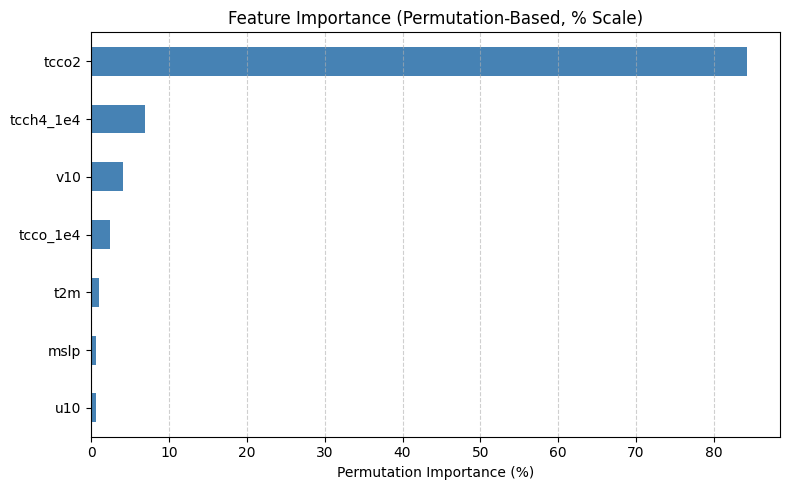

✅ Saved: feature_importance_percent.png

--- SHAP Importance Analysis ---

SHAP Importance in %:
mslp         1.5
u10          1.7
t2m          3.4
tcco_1e4     4.0
v10          6.7
tcch4_1e4   10.4
tcco2       72.2


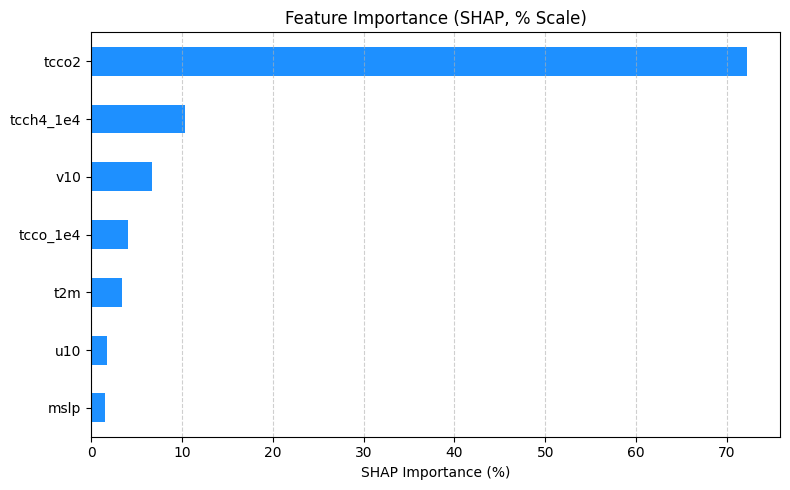

✅ Saved: shap_bar_plot_percent.png


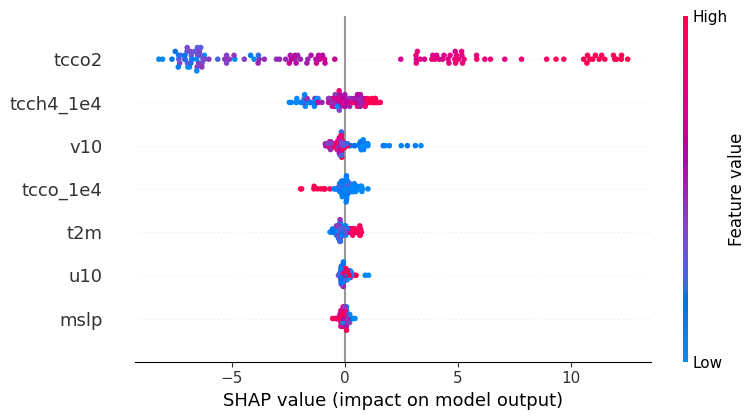

✅ Saved: shap_summary_plot.png


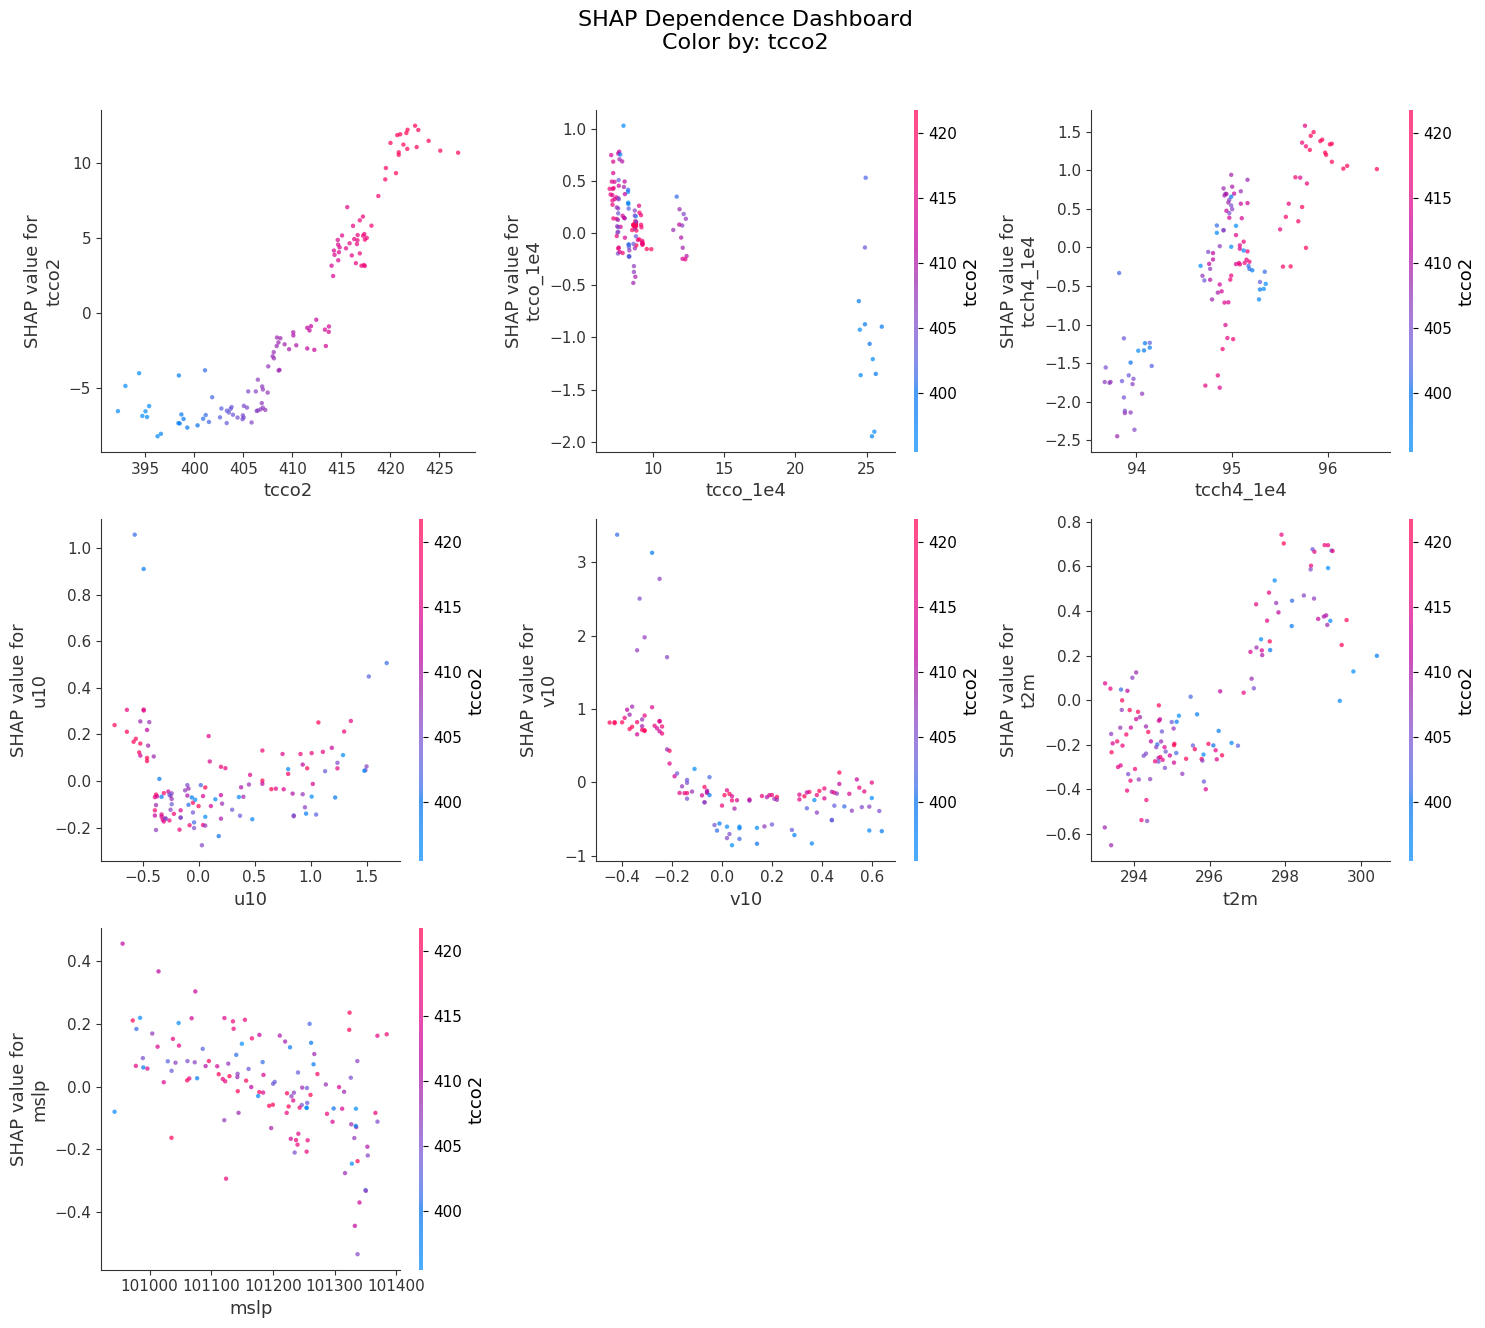

✅ Saved: shap_dependence_dashboard.png


In [3]:
# === Permutation importance ===
print("\n--- Permutation Importance Analysis ---")
importances = permutation_importance(model, X, y, n_repeats=30, random_state=42)
feature_importance = pd.Series(importances.importances_mean, index=X.columns).sort_values(ascending=False)

# Safely normalize and convert to percentages
total_importance = feature_importance.sum()

if total_importance > 0:
    feature_importance_percent = 100 * feature_importance / total_importance
else:
    feature_importance_percent = pd.Series(0, index=feature_importance.index)
    print("⚠️ Warning: Total importance is zero. Setting all values to 0%.")

# Sort for plotting
feature_importance_percent = feature_importance_percent.sort_values(ascending=True)
print("\nPermutation Importance in %:")
print(feature_importance_percent.to_string(float_format="{:.1f}".format))

# Plot
plt.figure(figsize=(8, 5))
feature_importance_percent.plot(kind='barh', color='steelblue')
plt.xlabel("Permutation Importance (%)")
plt.title("Feature Importance (Permutation-Based, % Scale)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("feature_importance_percent.png", dpi=300)
plt.show()
print("✅ Saved: feature_importance_percent.png")

# === SHAP Analysis for Random Forest ===
print("\n--- SHAP Importance Analysis ---")

# Create SHAP TreeExplainer for Random Forest
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X)

# SHAP Bar Plot in Percentages
# Compute mean absolute SHAP values
mean_shap_values = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_shap_values, index=X.columns)

# Normalize to percentage
total = shap_importance.sum()
shap_importance_percent = 100 * shap_importance / total

# Sort values
shap_importance_percent = shap_importance_percent.sort_values(ascending=True)
print("\nSHAP Importance in %:")
print(shap_importance_percent.to_string(float_format="{:.1f}".format))

# Plot as horizontal bar chart
plt.figure(figsize=(8, 5))
shap_importance_percent.plot(kind="barh", color="dodgerblue")
plt.xlabel("SHAP Importance (%)")
plt.title("Feature Importance (SHAP, % Scale)")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("shap_bar_plot.png", dpi=300)
plt.show()
print("✅ Saved: shap_bar_plot_percent.png")

# Save SHAP summary (beeswarm)
plt.figure()
shap.summary_plot(shap_values, X, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=300)
plt.show()
print("✅ Saved: shap_summary_plot.png")

# Ensure SHAP is using Matplotlib backend
shap.initjs()

# SHAP Dependence Dashboard
# Define features to include
features = X.columns.tolist()

# Create subplot grid
ncols = 3
nrows = int(np.ceil(len(features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4.5*nrows))

# Flatten axes for easy indexing
axes = axes.flatten()

# Create each dependence plot using co2obs for color
for i, feature in enumerate(features):
    #print(f"Plotting: {feature}")
    shap.dependence_plot(
        feature,
        shap_values,
        X,
        interaction_index="tcco2",  # Fixed color dimension
        ax=axes[i],
        show=False,
        dot_size=10,
        alpha=0.7
    )

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Add title and layout
fig.suptitle("SHAP Dependence Dashboard\nColor by: tcco2", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("shap_dependence_dashboard.png", dpi=300)
plt.show()
print("✅ Saved: shap_dependence_dashboard.png")


### 🔹 Part D – Save Model, Export Predictions, and Visualize Results

This section finalizes the Random Forest modeling by saving the trained model, exporting predictions, computing accuracy metrics, and visualizing the results using both scatter and time series plots.


#### 💾 Save the Trained Model and Predictions
- The trained **Random Forest model** is saved using `joblib` to: `random_forest_co2_model.pkl`
- Predicted ground-level CO₂ (`predicted_rf_co2`) is added as a new column to the original DataFrame.
- The updated dataset, now including predictions, is exported as: `co2_predictions_random_forest.csv`


#### 🧮 Evaluate Model Accuracy
The script calculates performance metrics to compare:
1. **`predicted_rf_co2`** vs **`co2obs`**
2. **`tcco2`** (Total Column CO₂) vs **`co2obs`** (Observed CO₂)  

The reported metrics include:
- **R²** (Coefficient of Determination)
- **MAE** (Mean Absolute Error)
- **MBE** (Mean Bias Error)

These provide a quantitative comparison of how well the model performs versus a simple direct column comparison.

#### 📊 Scatter Plot: Observed vs Predicted
- A **scatter plot** visualizes the relationship between `co2obs` and `predicted_rf_co2`.
- A red dashed 1:1 reference line helps assess model accuracy.  
  📁 Saved as: `rf_scatter_plot.png`

#### 📈 Time Series Plot: Observed, Column, and Predicted CO₂
- A **line plot** is generated to show all three CO₂ variables over time:
- Observed ground-level CO₂ (`co2obs`) – red
- Total column CO₂ (`tcco2`) – green dashed
- Predicted CO₂ from Random Forest (`predicted_rf_co2`) – blue  
  📁 Saved as: `co2_timeseries_comparison.png`


> ✅ This step ensures both **model preservation** and clear, interpretable **evaluation of model performance**, both statistically and visually.


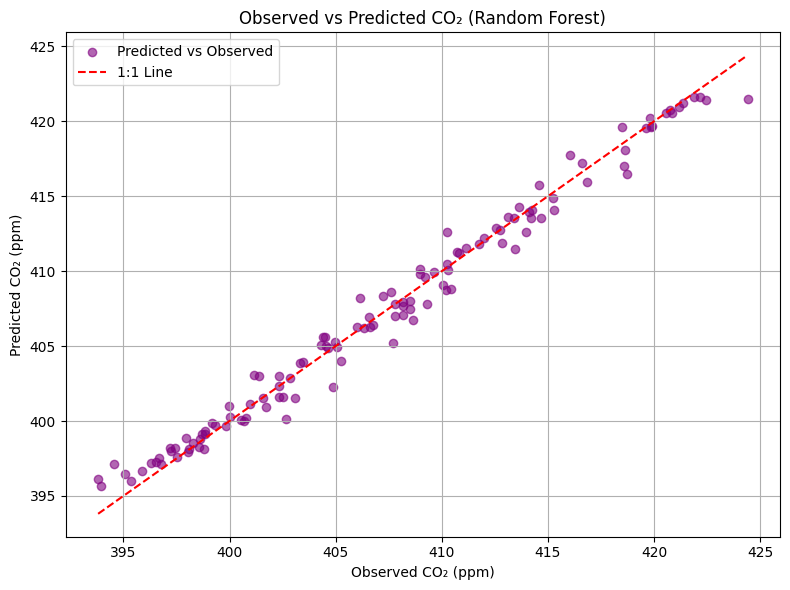

✅ Saved: rf_scatter_plot.png


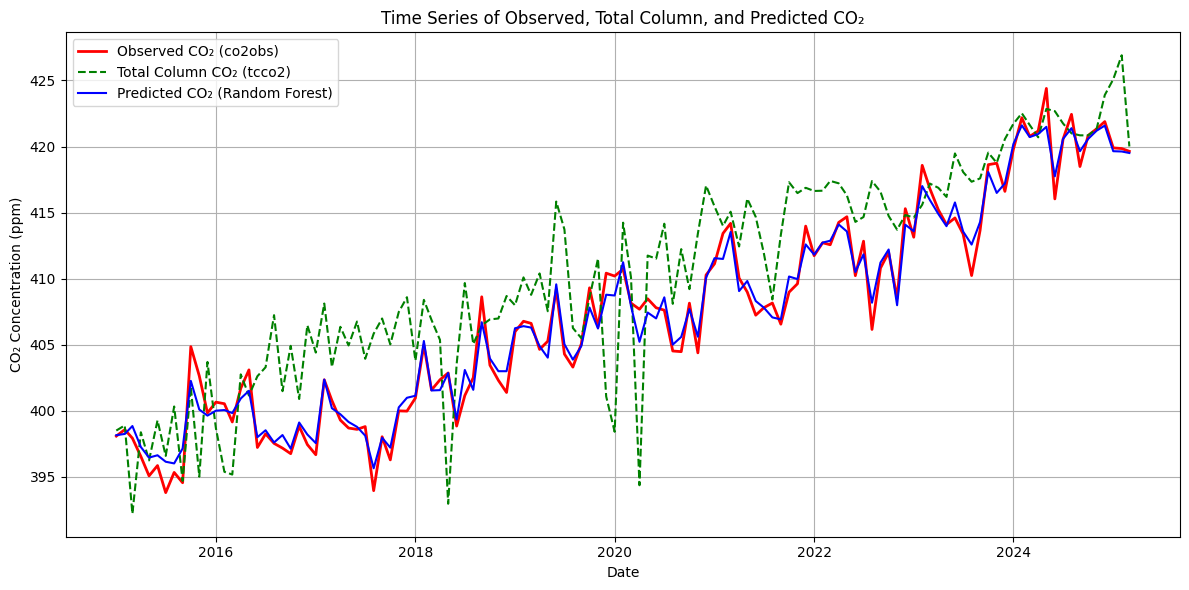

✅ Saved: co2_timeseries_comparison.png
--- Metrics: co2obs vs tcco2 ---
R² = 0.548, MAE = 4.299 ppm, MBE = 2.940 ppm

--- Metrics: co2obs vs predicted_rf_co2 ---
R² = 0.983, MAE = 0.780 ppm, MBE = 0.001 ppm


In [4]:
# === Save model and predictions ===
joblib.dump(model, "random_forest_co2_model.pkl")
df["predicted_rf_co2"] = y_pred
df.to_csv("co2_predictions_random_forest.csv", index=False)

# === Ensure datetime format ===
df["date"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2) + "-01")

# === Scatter plot: Observed vs Predicted ===
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, color='purple', alpha=0.6, label='Predicted vs Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 Line')
plt.xlabel('Observed CO₂ (ppm)')
plt.ylabel('Predicted CO₂ (ppm)')
plt.title('Observed vs Predicted CO₂ (Random Forest)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rf_scatter_plot.png", dpi=300)
plt.show()
print("✅ Saved: rf_scatter_plot.png")

# === Plot time series ===
plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["co2obs"], label="Observed CO₂ (co2obs)", color="red", linewidth=2)
plt.plot(df["date"], df["tcco2"], label="Total Column CO₂ (tcco2)", color="green", linestyle="--")
plt.plot(df["date"], df["predicted_rf_co2"], label="Predicted CO₂ (Random Forest)", color="blue")

plt.xlabel("Date")
plt.ylabel("CO₂ Concentration (ppm)")
plt.title("Time Series of Observed, Total Column, and Predicted CO₂")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("co2_timeseries_comparison.png", dpi=300)
plt.show()
print("✅ Saved: co2_timeseries_comparison.png")

# === Compute Metrics ===
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mbe = np.mean(y_pred - y_true)
    return r2, mae, mbe

# Metrics for tcco2
r2_tcco2, mae_tcco2, mbe_tcco2 = compute_metrics(df["co2obs"], df["tcco2"])

# Metrics for predicted_rf_co2
r2_pred, mae_pred, mbe_pred = compute_metrics(df["co2obs"], df["predicted_rf_co2"])

# === Print metrics ===
print("--- Metrics: co2obs vs tcco2 ---")
print(f"R² = {r2_tcco2:.3f}, MAE = {mae_tcco2:.3f} ppm, MBE = {mbe_tcco2:.3f} ppm")

print("\n--- Metrics: co2obs vs predicted_rf_co2 ---")
print(f"R² = {r2_pred:.3f}, MAE = {mae_pred:.3f} ppm, MBE = {mbe_pred:.3f} ppm")


### 🔹 Part E – Time Series Forecasting Using SARIMA

In this section, we use **SARIMA (Seasonal AutoRegressive Integrated Moving Average)** to model and forecast CO₂ concentration for the next 12 months based on the predictions from the Random Forest model.


#### 📆 Time Series Setup
- We create a `datetime` index from the `year` and `month` columns.
- The target time series is `predicted_rf_co2`, already generated by the Random Forest model.
- The series is sorted and converted to monthly frequency (`MS`).


#### 🔎 SARIMA Model and Optimization
- SARIMA is denoted as: **SARIMA(p, d, q)(P, D, Q, S)**:
  - **p, d, q**: Non-seasonal autoregression, differencing, and moving average orders
  - **P, D, Q**: Seasonal equivalents
  - **S**: Seasonal period (12 for monthly data with yearly cycles)
  
- The `optimize_sarima()` function performs **grid search** over small parameter ranges:
  - All combinations of (0, 1) for p, d, q and seasonal P, D, Q
  - The best model is selected based on **lowest AIC (Akaike Information Criterion)**


#### 🔮 Forecasting Next 12 Months
- After selecting the optimal SARIMA configuration, we forecast the **next 12 time steps** (months).
- The forecast includes:
  - **Predicted CO₂ values**
  - **95% confidence intervals (CI)**  
  📁 Saved as: `sarima_forecast_next_12_months.csv`


#### 📈 Forecast Plot
- Two time series line charts are generated:
- Historical Random Forest predictions (gray)
- SARIMA forecast (blue line)
- Confidence interval (shaded blue area)

  📁 Saved as: `sarima_forecast_plot.png` and `co2_last6_forecast12.png`

> ✅ This step combines machine learning predictions with classic time series modeling to generate a reliable and interpretable forecast of atmospheric CO₂.



--- SARIMA Forecast for Next 12 Months ---
Best SARIMA order: ((0, 1, 1), (0, 1, 1, 12))
         date  forecasted_co2    lower_ci    upper_ci
0  2025-04-01      419.782383  416.271532  423.293234
1  2025-05-01      419.951913  416.230933  423.672893
2  2025-06-01      419.085423  415.165562  423.005284
3  2025-07-01      419.250693  415.141566  423.359820
4  2025-08-01      417.816653  413.526602  422.106705
5  2025-09-01      419.175103  414.711454  423.638751
6  2025-10-01      420.631513  416.000770  425.262255
7  2025-11-01      419.915803  415.123790  424.707816
8  2025-12-01      421.535943  416.587912  426.483973
9  2026-01-01      421.967259  416.867982  427.066535
10 2026-02-01      423.645219  418.397885  428.892554
11 2026-03-01      422.841910  417.452886  428.230934


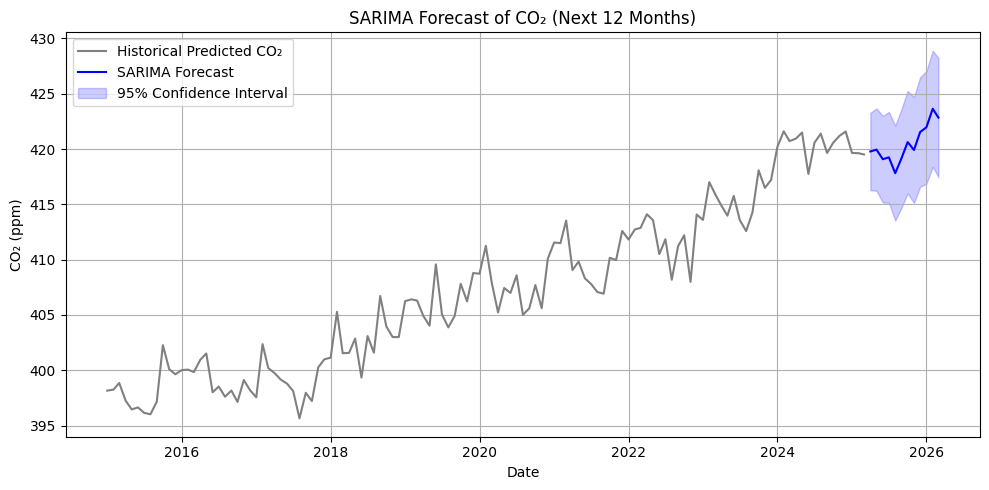

✅ Saved: sarima_forecast_plot.png


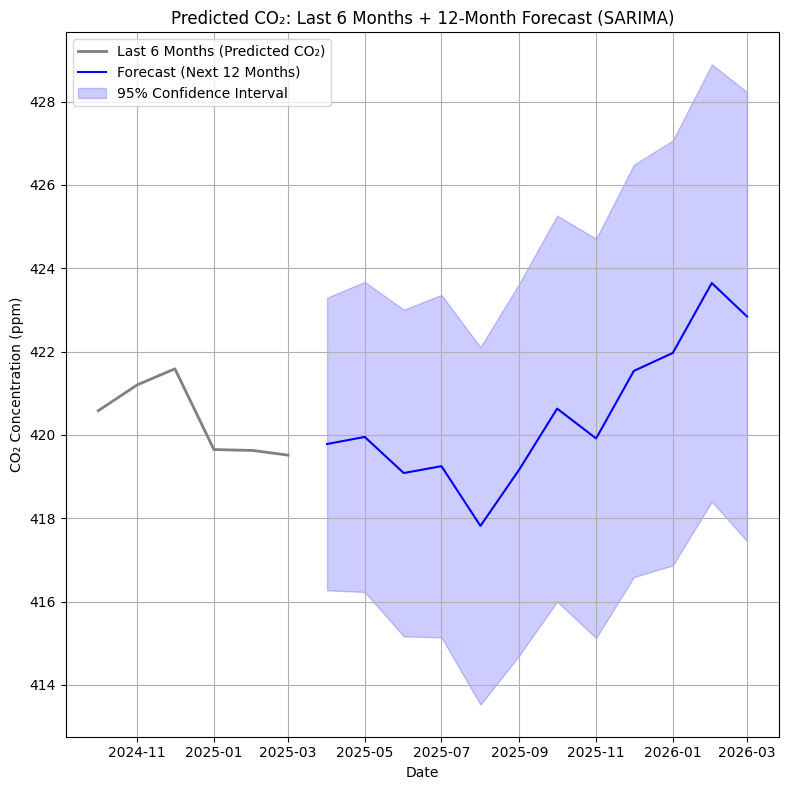

✅ Saved: co2_last6_forecast12.png


In [5]:
# === SARIMA Forecast ===
print("\n--- SARIMA Forecast for Next 12 Months ---")
df["date"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2) + "-01")
ts = pd.Series(df["predicted_rf_co2"].values, index=df["date"]).sort_index()

def optimize_sarima(ts, pdq_range, seasonal_pdq_range):
    best_aic = float("inf")
    best_order = None
    best_model = None
    for order in pdq_range:
        for s_order in seasonal_pdq_range:
            try:
                model = SARIMAX(ts, order=order, seasonal_order=s_order,
                                enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (order, s_order)
                    best_model = results
            except:
                continue
    return best_model, best_order

# Optimize SARIMA
p = d = q = range(0, 2)
pdq = [(x, y, z) for x in p for y in d for z in q]
seasonal_pdq = [(x, y, z, 12) for x in p for y in d for z in q]

sarima_result, best_order = optimize_sarima(ts, pdq, seasonal_pdq)
print(f"Best SARIMA order: {best_order}")

# Forecast
forecast = sarima_result.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_start = ts.index.max() + pd.DateOffset(months=1)
forecast_dates = pd.date_range(start=forecast_start, periods=12, freq='MS')

forecast_df = pd.DataFrame({
    "date": forecast_dates,
    "forecasted_co2": forecast_mean.values,
    "lower_ci": forecast_ci.iloc[:, 0].values,
    "upper_ci": forecast_ci.iloc[:, 1].values
})
forecast_df.to_csv("sarima_forecast_next_12_months.csv", index=False)
print(forecast_df)

# === Plot forecast ===
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts.values, label='Historical Predicted CO₂', color='gray')
plt.plot(forecast_df["date"], forecast_df["forecasted_co2"], label='SARIMA Forecast', color='blue')
plt.fill_between(forecast_df["date"], forecast_df["lower_ci"], forecast_df["upper_ci"], color='blue',
                 alpha=0.2, label="95% Confidence Interval")
plt.title("SARIMA Forecast of CO₂ (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sarima_forecast_plot.png", dpi=300)
plt.show()
print("✅ Saved: sarima_forecast_plot.png")

# === Filter last 6 months of historical data ===

# Load data
df_hist = pd.read_csv("co2_predictions_random_forest.csv")
df_forecast = pd.read_csv("sarima_forecast_next_12_months.csv")

# Ensure datetime format
df_hist["date"] = pd.to_datetime(df_hist["year"].astype(str) + "-" + df_hist["month"].astype(str).str.zfill(2) + "-01")
df_forecast["date"] = pd.to_datetime(df_forecast["date"])
last_6_months = df_hist.sort_values("date").iloc[-6:]

# Plot
plt.figure(figsize=(8, 8))
plt.plot(last_6_months["date"], last_6_months["predicted_rf_co2"], label="Last 6 Months (Predicted CO₂)", color="gray", linewidth=2)
plt.plot(df_forecast["date"], df_forecast["forecasted_co2"], label="Forecast (Next 12 Months)", color="blue")
plt.fill_between(df_forecast["date"], df_forecast["lower_ci"], df_forecast["upper_ci"],
                 color="blue", alpha=0.2, label="95% Confidence Interval")

plt.xlabel("Date")
plt.ylabel("CO₂ Concentration (ppm)")
plt.title("Predicted CO₂: Last 6 Months + 12-Month Forecast (SARIMA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("co2_last6_forecast12.png", dpi=300)
plt.show()
print("✅ Saved: co2_last6_forecast12.png")


### 🔹 Part F – Seasonal Decomposition of Predicted CO₂

This section performs **time series decomposition** on the predicted CO₂ values generated by the Random Forest model to better understand its underlying components.


#### 📉 What is Seasonal Decomposition?
- Decomposes the time series into three components:
  - **Trend**: The long-term direction of the data
  - **Seasonal**: The repeating pattern (e.g., annual cycle)
  - **Residual**: Random noise or irregular fluctuations

- The model used here is **additive**, which assumes: predicted = trend + seasonal + residual


#### 🧩 Decomposition & Visualization
- `seasonal_decompose()` from `statsmodels` is used with a **seasonal period of 12 months**.
- A multi-panel plot is created showing:
- Original series
- Extracted trend
- Seasonal component
- Residuals  
  📁 Saved as: `seasonal_decomposition_rf_co2.png`


#### 📁 Save Decomposition Results
- All components are combined into a DataFrame and exported as: seasonal_decomposition_rf_co2.csv
- A new variable `trend_plus_seasonal` is computed as the sum of the trend and seasonal components.


#### 📈 Plot: Trend + Seasonal vs Predicted CO₂
- A line plot compares:
- Predicted CO₂ (gray)
- Smoothed trend + seasonal signal (blue)
- This helps visualize how much of the predicted series is explained by systematic patterns.  
  📁 Saved as: `trend_plus_seasonal_timeseries.png`


> ✅ Decomposition helps diagnose the time series structure, confirm seasonality, and assess forecast suitability.


--- Seasonal Decomposition of Predicted CO₂ ---


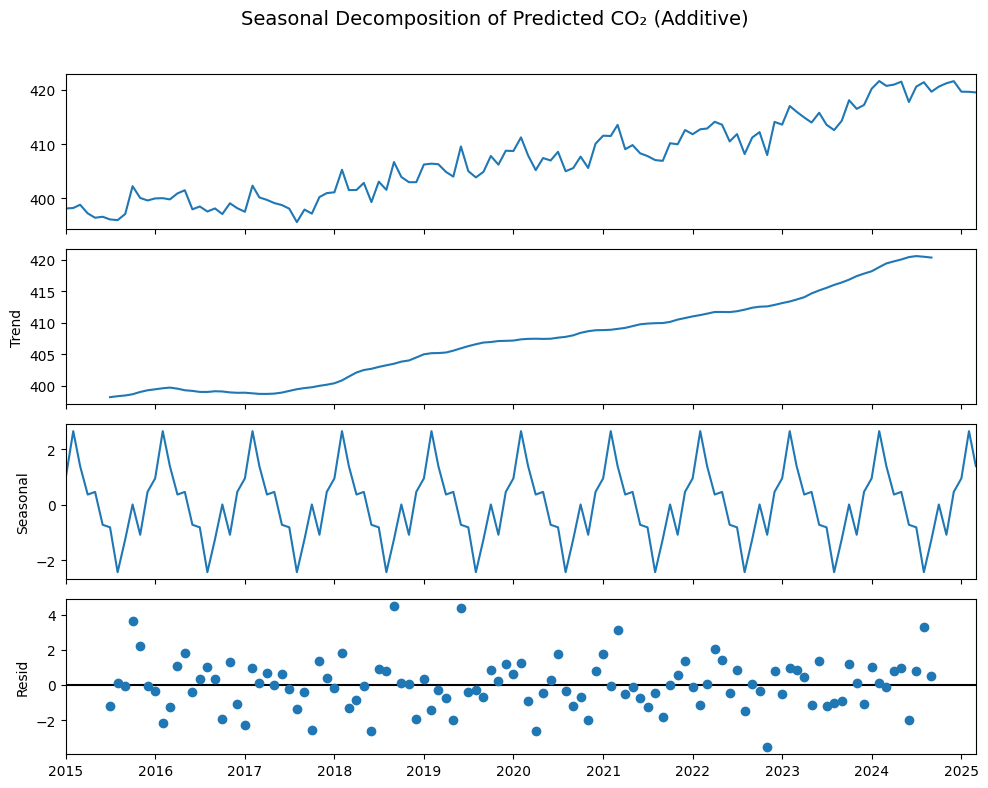

✅ Saved: seasonal_decomposition_rf_co2.png
Saved: seasonal_decomposition_rf_co2.csv


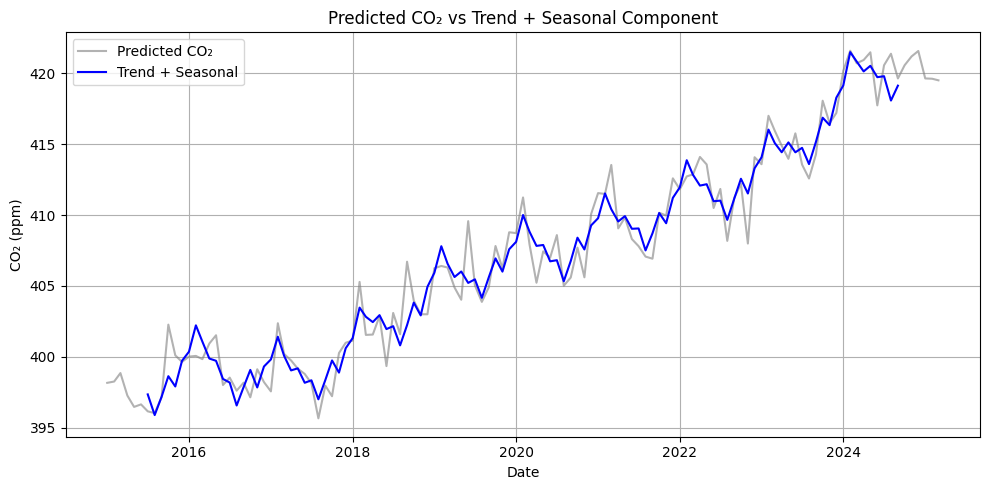

✅ Saved: trend_plus_seasonal_timeseries.png


In [6]:
# === Seasonal Decomposition of the predicted CO₂ ===
print("\n--- Seasonal Decomposition of Predicted CO₂ ---")
ts = ts.asfreq('MS')  # ensure monthly frequency for decomposition

decomposition = seasonal_decompose(ts, model='additive', period=12)

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.suptitle("Seasonal Decomposition of Predicted CO₂ (Additive)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("seasonal_decomposition_rf_co2.png", dpi=300)
plt.show()
print("✅ Saved: seasonal_decomposition_rf_co2.png")

# === Combine components into a DataFrame ===
decomp_df = pd.DataFrame({
    "date": ts.index,
    "predicted": ts.values,
    "trend": decomposition.trend,
    "seasonal": decomposition.seasonal,
    "residual": decomposition.resid,
    "trend_plus_seasonal": decomposition.trend + decomposition.seasonal
})

# === Save decomposition result to CSV ===
decomp_df.to_csv("seasonal_decomposition_rf_co2.csv", index=False)
print("Saved: seasonal_decomposition_rf_co2.csv")

# === Plot trend + seasonal overlay ===
plt.figure(figsize=(10, 5))
plt.plot(decomp_df["date"], decomp_df["predicted"], label="Predicted CO₂", color='gray', alpha=0.6)
plt.plot(decomp_df["date"], decomp_df["trend_plus_seasonal"], label="Trend + Seasonal", color='blue')
plt.title("Predicted CO₂ vs Trend + Seasonal Component")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("trend_plus_seasonal_timeseries.png", dpi=300)
plt.show()
print("✅ Saved: trend_plus_seasonal_timeseries.png")


### 🔹 Conclusion


This notebook demonstrates an integrated approach to modeling and forecasting ground-level CO₂ concentrations using a combination of **machine learning** and **time series analysis**.

By applying a **Random Forest Regressor** for spatial and physical predictor modeling and a **SARIMA model** for capturing temporal dynamics, we are able to construct a robust, data-driven framework for both short-term prediction and long-term forecasting.

Additionally, **seasonal decomposition** provides valuable insights into the underlying structure of the CO₂ time series, helping identify long-term trends and recurring seasonal patterns.

> 🧠 This hybrid method is adaptable, interpretable, and well-suited for operational applications in environmental monitoring, climate modeling, and policy support.


---

### 💾 Note: Work from Your Google Drive Folder

To save and access files directly in your Google Drive, you can mount your Drive and navigate to your working directory using the code below:

```python
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ # Write the directory on Google Drive you want to work from



---

Page curated by: Alberth Nahas (alberth.nahas@bmkg.go.id)

Last modified: 2025-04-19